### Домашнее задание №7 по теме «Работа с переменными»

In [1]:
import reverse_geocoder as revgc  
import pickle
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from tqdm import tqdm
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from category_encoders.count import CountEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (r2_score, mean_squared_error)
pd.options.display.float_format = '{:.3f}'.format

#### Задание  
В домашнем задании нужно улучшить метрики RMSE, R2 модели линейной регрессии путем работы с данными, а именно проведения разведочного анализа данных. В качестве датасета необходимо загрузить данные о недвижимости Калифорнии из библиотеки sklearn.datasets. Целевая переменная – MedHouseVal. Прочитать информацию о признаках датасета можно, выполнив следующий код -  `print(fetch_california_housing().DESCR).`  


#### Этапы работы:
1. Получите данные и загрузите их в рабочую среду.  
2. Проверьте данные на наличие пропусков. Удалите их в случае обнаружения.
3. Разделите выборку на обучающее и тестовое подмножества. 80% данных оставить на обучающее множество, 20% - на тестовое.
4. Постройте модель линейной регрессии. Вычислите метрики RMSE, R2 на обучающем и тестовом множестве.
5. Постройте график распределения целевой переменной. Сделайте вывод. Присутствуют ли в этом признаке выбросы?
6. Посчитайте и выведите корреляционную матрицу. Убедитесь, что ячейки матрицы поделены на цветные категории, в ячейках указано числовое значение корреляции.  
    a. Сделайте выводы.  
    b. Удалите признаки на основании полученных значений, выводов.  
    c. Повторите п. 3, п. 4 на измененных данных.  
7. Исследуйте оставленные признаки на выбросы.  
    a. Удалите выбросы в случае обнаружения.  
    b. Повторите п. 3, п. 4 на измененных данных.  
8. Измените несколько признаков на выбор математически. Например, вычислите логарифм, возведите в квадрат, извлеките квадратный корень.
    a. Повторите п. 3, п. 4 на измененных данных.  
9. Сформулируйте выводы по проделанной работе.  
    a. Кратко опишите какие преобразования были сделаны с данными.  
    b. Сравните метрики всех моделей. Желательно оформление в виде таблицы вида |модель|RMSE|R2|признаки, на которых проводилось обучение с указанием их преобразований|.  
    c. Напишите свое мнение, в полной ли мере модели справились с поставленной задачей.  
____
Для получения зачета по этому домашнему заданию, минимально, должно быть реализовано обучение трех моделей классификации: на основе всех неизмененных признаков; на основе признаков, отобранных по значениям корреляций; на основе признаков, отобранных по значениям корреляций и с удалением выбросов в них. Должны быть выведены метрики RMSE, R2 моделей. Желательно добиться улучшения метрик.

#### 1. Загружаем данные

In [2]:
california_housing = fetch_california_housing(as_frame=True)

In [3]:
print(fetch_california_housing().DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [4]:
df = california_housing.frame

In [5]:
df.head(7)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.325,41.000,6.984,1.024,322.000,2.556,37.880,-122.230,4.526
1,8.301,21.000,6.238,0.972,2401.000,2.110,37.860,-122.220,3.585
2,7.257,52.000,8.288,1.073,496.000,2.802,37.850,-122.240,3.521
3,5.643,52.000,5.817,1.073,558.000,2.548,37.850,-122.250,3.413
4,3.846,52.000,6.282,1.081,565.000,2.181,37.850,-122.250,3.422
5,4.037,52.000,4.762,1.104,413.000,2.140,37.850,-122.250,2.697
6,3.659,52.000,4.932,0.951,1094.000,2.128,37.840,-122.250,2.992


#### 2. Пропуски

In [6]:
pd.concat([df.isnull().sum().rename('cnt'), round((df.isna().mean() * 100),2).rename('%')], axis=1)

,cnt,%
MedInc,0,0.000
HouseAge,0,0.000
AveRooms,0,0.000
AveBedrms,0,0.000
Population,0,0.000
AveOccup,0,0.000
Latitude,0,0.000
Longitude,0,0.000
MedHouseVal,0,0.000


Пропусков нет. Но это и было указано в описании датасета.

##### \*графики

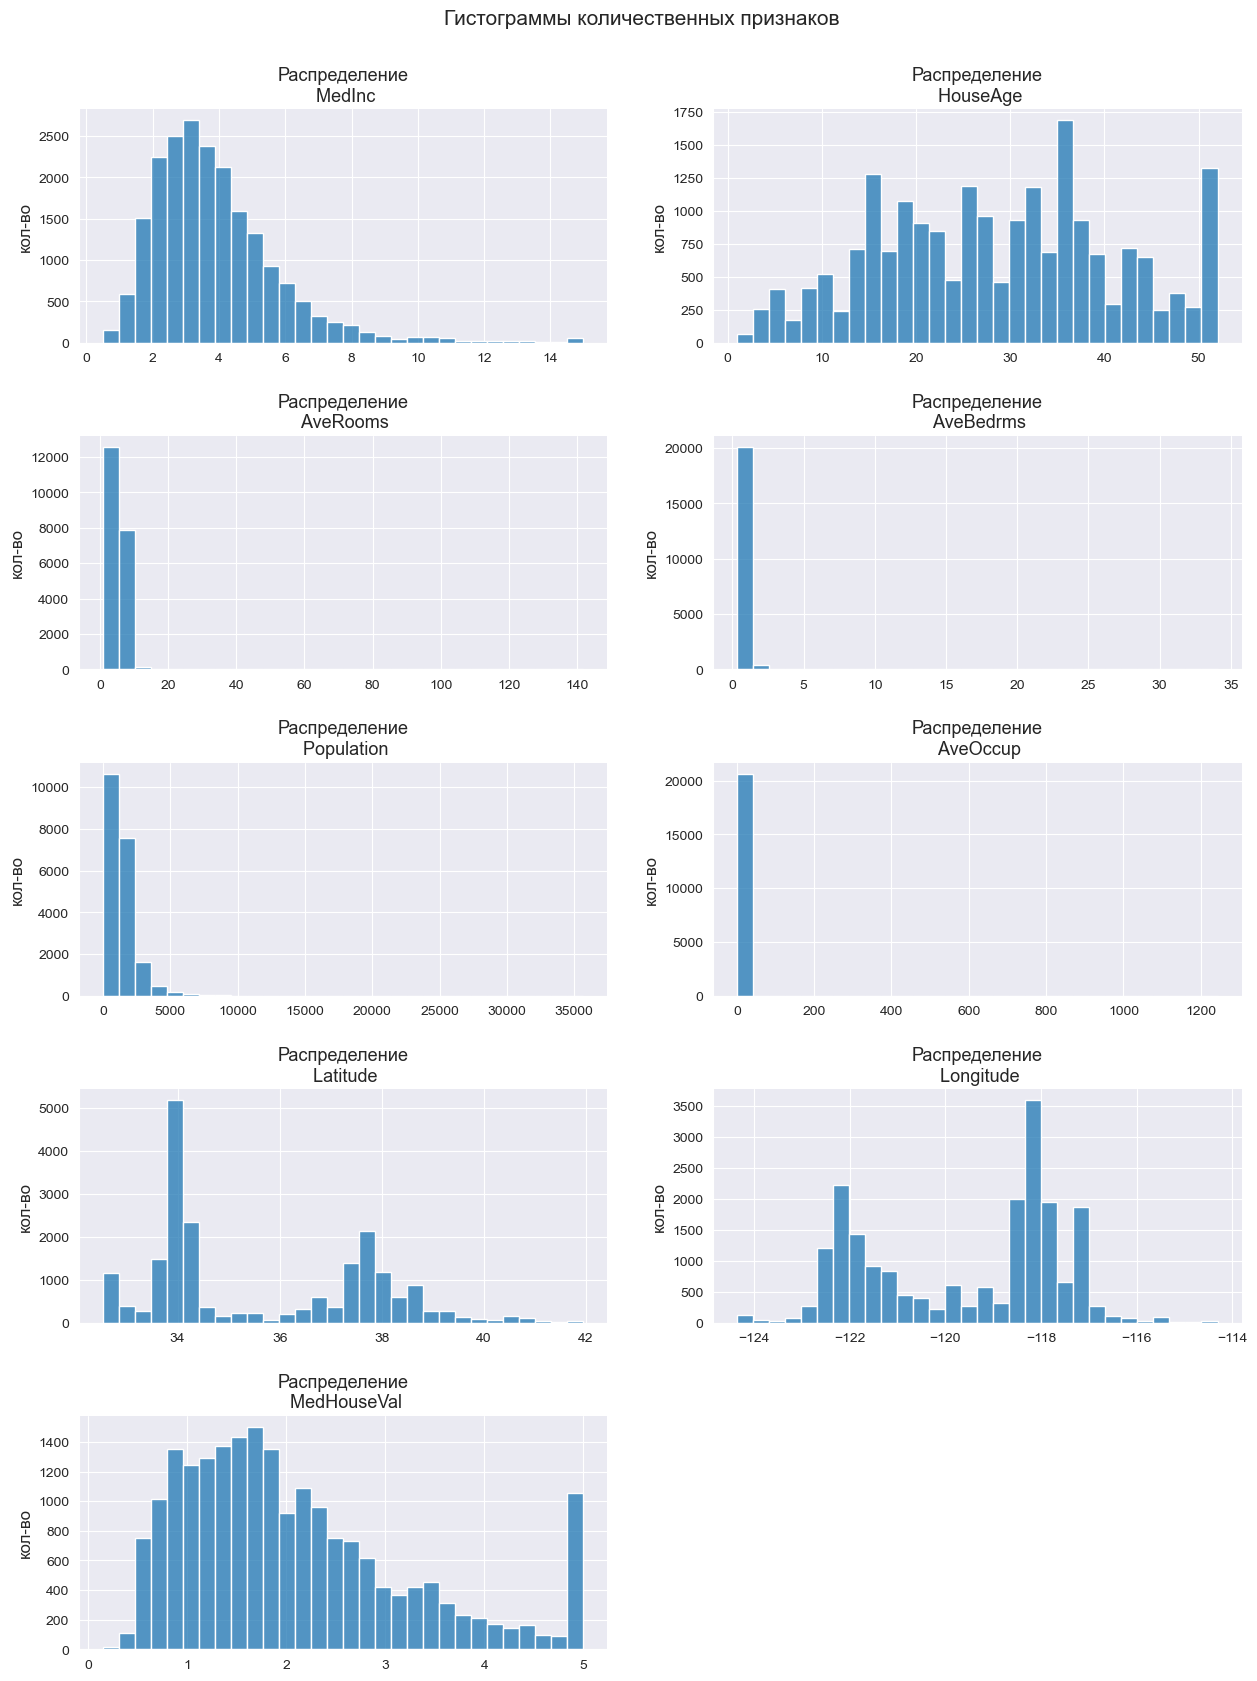

In [7]:
fig = plt.figure(figsize=(15,20))
cols = [k for k,v in df.dtypes.to_dict().items() if v in ['float', 'int']]
for i,col in enumerate(cols):
    fig.add_subplot(5, 2, i+1)
    sns.histplot(data=df, x=col, kde=False, bins=30)
    plt.title(f'Распределение\n {col}', size=13)
    plt.xlabel('', size=12)
    sns.despine()
    plt.ylabel('кол-во', size=12)
plt.suptitle('Гистограммы количественных признаков', size=15, y=0.93)
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

На первый взгляд следующие выводы:
1. Пропусков нет
2. Средний доход в блоке распределен ожидаемо - есть хвост в сторону богачей
3. Возраст домов распределен нормально за исключением большого количество старых домов свыше 50 лет
4. Среднее кол-во комнат, ванных, население, владельцы распределены с сильными тяжелыми хвостами. Это скорее всего многоквартиные дома
5. В широте и долготе есть пики. Это видимо скопления домов в некоторых пересечениях координат

In [8]:
cali_map = gpd.read_file('https://raw.githubusercontent.com/ropensci/geojsonio/main/inst/examples/california.geojson')
cali_data = df.groupby(['Latitude','Longitude']).agg({'MedHouseVal':'count'}).reset_index()

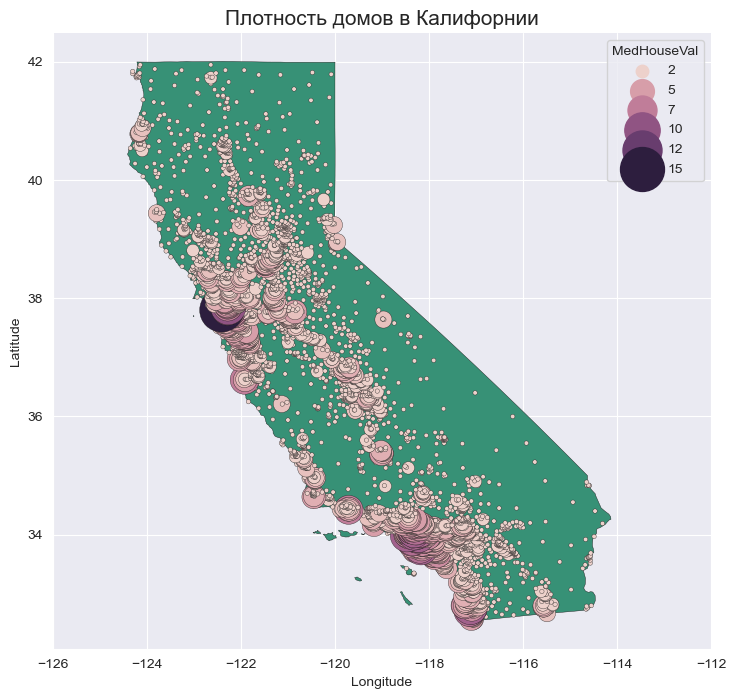

In [9]:
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(10, 8))
cali_map.plot(color='#379176', linewidth=0.3, ax=axs, edgecolor='0.1').set_xlim([-126, -112])
sns.despine()
sns.scatterplot(data=cali_data, 
                x="Longitude", 
                y="Latitude", 
                hue="MedHouseVal", 
                size="MedHouseVal", 
                sizes=(10, 1000),
                hue_norm=(2, 15),
                color='b',
                edgecolor='0.1',
                ax = axs)
plt.title('Плотность домов в Калифорнии', size=15)
plt.show()

Действительно. Дома сгруппированы в крупных населенных пунктах. Сан-Франциско, Лос-Анджелес, Сан-Хосе

Подготовим функции для преобразования столбцов и вывода метрик

In [10]:
def get_one_hot(df, cols):
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each)
        df = pd.concat([df, dummies], axis=1)
    return df

def get_label(df, cols):
    df = df.copy()
    for each in cols:
        le = LabelEncoder()
        labels = le.fit_transform(df[each])
        df[each] = labels
    return df

def get_count(df, cols):
    df = df.copy()
    
    for col in cols:
        df[col] = df[col].astype('str')

    ce = CountEncoder(handle_unknown=-1)
    ce.fit(df[cols])
    df[cols] = ce.transform(df[cols])
    return df

def get_log(df, cols):
    df = df.copy()
    for each in cols:
        df[each] = np.log(df[each] + 1e-10)
    return df

In [11]:
def get_score(df, target, random_seed=42, model=None, title='Baseline'):
    if model is None:
        model = LinearRegression()
    
    y = df[target]
    X = df.drop([target], axis = 1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed) 

    scaler = StandardScaler()
    X_st_train = scaler.fit_transform(X_train)
    X_st_test = scaler.transform(X_test)


    model.fit(X_st_train, y_train)
    y_pred_train = model.predict(X_st_train)
    y_pred_test = model.predict(X_st_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_train = mean_squared_error(y_train, y_pred_train)**.5
    rmse_test = mean_squared_error(y_test, y_pred_test)**.5
    metrix = {}
    metrix['r2_train'] = r2_train
    metrix['r2_test'] = r2_test
    metrix['rmse_train'] = rmse_train
    metrix['rmse_test'] = rmse_test
    res = pd.DataFrame.from_dict(metrix, orient='index', columns=[title])
    return res

Вспомним что значат метрики:  

$$ R^2 = 1 - \frac{\sum_{i=1}^{N}\left(y_i - \hat{y} \right)^2}{\sum_{i=1}^{N}\left(\bar{y} - y_i \right)^2}$$
где
$$ \bar{y} = \frac{1}{n} * \sum_{i=1}^{N}y_i $$

$$ RMSE = \sqrt{\frac{1}{n} * \sum_{i=1}^{N}\left(y_i - \hat{y} \right)^2} $$


__R2__ В идеале числитель должен быть минимальным, следовательно правая часть уравнения должна стремиться к 0. Метрика принимает значения от 0 до 1. Чем ближе к 1 тем лучше  
__RMSE__ Чем меньше предсказанное значение отличается от реального том меньше сумма таких разниц, следовательно тем меньше их среднее значение и корень. Метрика лучше ближе к 0.

#### 3-4 Baseline

In [12]:
res_0 = get_score(df, 'MedHouseVal', title='Baseline')

In [13]:
res = res_0.copy()

In [14]:
res

,Baseline
r2_train,0.613
r2_test,0.576
rmse_train,0.720
rmse_test,0.746


Если не делать никаких преобразований, метрики обычные. На тесте модель чуть хуже - значит переучивается

#### 5. Целевая переменная 

In [15]:
stat = df.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T
stat

,count,mean,std,min,5%,25%,50%,75%,95%,99%,max
MedInc,20640.000,3.871,1.900,0.500,1.601,2.563,3.535,4.743,7.300,10.597,15.000
HouseAge,20640.000,28.639,12.586,1.000,8.000,18.000,29.000,37.000,52.000,52.000,52.000
AveRooms,20640.000,5.429,2.474,0.846,3.432,4.441,5.229,6.052,7.640,10.357,141.909
AveBedrms,20640.000,1.097,0.474,0.333,0.939,1.006,1.049,1.100,1.273,2.128,34.067
Population,20640.000,1425.477,1132.462,3.000,348.000,787.000,1166.000,1725.000,3288.000,5805.830,35682.000
AveOccup,20640.000,3.071,10.386,0.692,1.873,2.430,2.818,3.282,4.333,5.395,1243.333
Latitude,20640.000,35.632,2.136,32.540,32.820,33.930,34.260,37.710,38.960,40.626,41.950
Longitude,20640.000,-119.570,2.004,-124.350,-122.470,-121.800,-118.490,-118.010,-117.080,-116.290,-114.310
MedHouseVal,20640.000,2.069,1.154,0.150,0.662,1.196,1.797,2.647,4.898,5.000,5.000


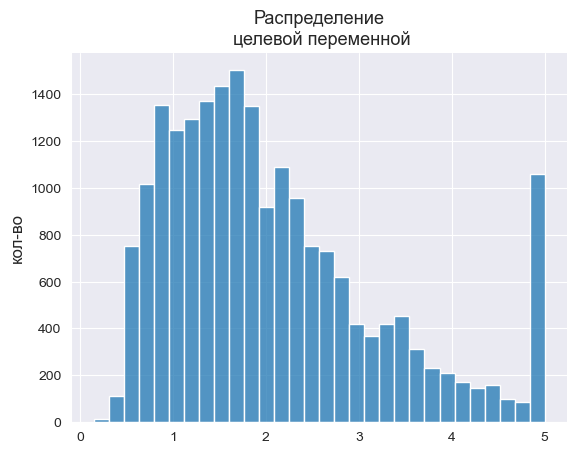

In [16]:
sns.histplot(data = df, x='MedHouseVal', kde=False, bins=30)
plt.title(f'Распределение\n целевой переменной', size=13)
plt.xlabel('', size=12)
sns.despine()
plt.ylabel('кол-во', size=12)
plt.show()

In [17]:
q_low = stat.loc['MedHouseVal','5%']
q_up = stat.loc['MedHouseVal','95%']

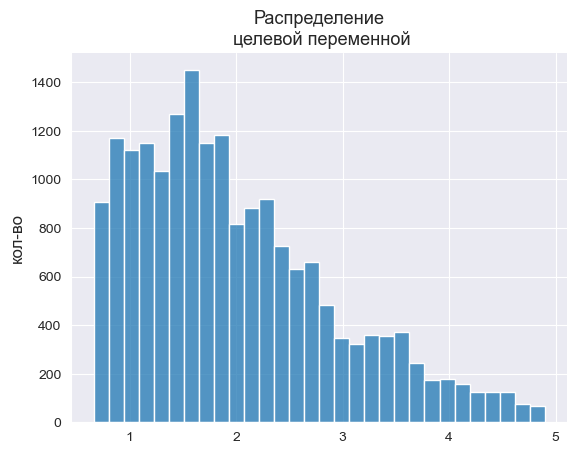

In [18]:
sns.histplot(data = df.query('@q_low < MedHouseVal <@q_up'), x='MedHouseVal', kde=False, bins=30)
plt.title(f'Распределение\n целевой переменной', size=13)
plt.xlabel('', size=12)
sns.despine()
plt.ylabel('кол-во', size=12)
plt.show()

In [19]:
print(f"Датасет с выбросами ЦП: {df.shape}")
print(f"Датасет без выбросов ЦП: {df.query('@q_low < MedHouseVal <@q_up').shape}")

Датасет с выбросами ЦП: (20640, 9)
Датасет без выбросов ЦП: (18575, 9)


In [20]:
res_1 = get_score(df.query('@q_low < MedHouseVal <@q_up'), 'MedHouseVal', title='Drop_target_outlers')

In [21]:
res = pd.concat([res, res_1], axis=1)

In [22]:
res

,Baseline,Drop_target_outlers
r2_train,0.613,0.541
r2_test,0.576,0.521
rmse_train,0.720,0.628
rmse_test,0.746,0.659


У целевой переменной есть не то бы выбросы - около 1000 домов со стоимостью свыше 500000$. Это скорее всего те самые многоквартирные дома с большим числом комнат и спален. Удалив эти значения как выбросы R2 ухудшилась, а RMSE улучшилась.

#### 6. Корреляционная матрица

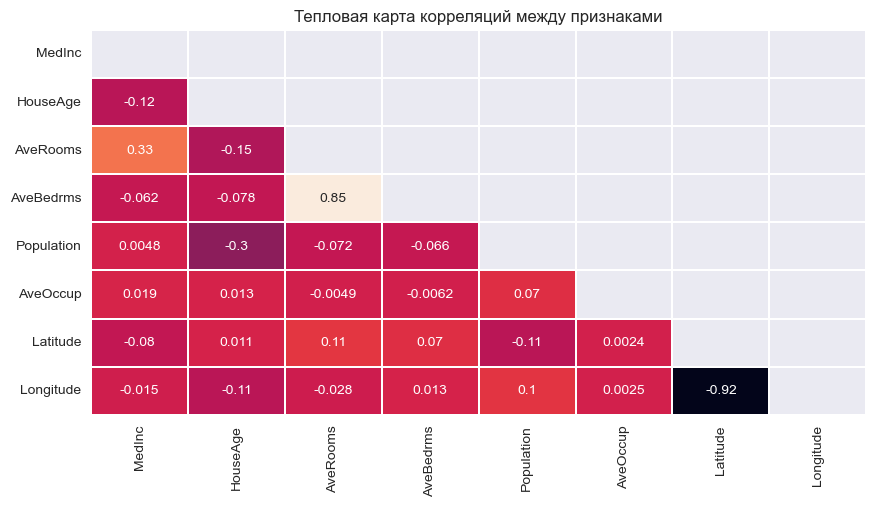

In [23]:
fig = plt.figure(figsize=(10,5))
mask = np.triu(df.drop(columns=['MedHouseVal']).corr())
sns.heatmap(df.drop(columns=['MedHouseVal']).corr(), annot=True, fmt='.2g', mask=mask, linecolor = 'white', linewidths=0.3, cbar=False)
plt.title('Тепловая карта корреляций между признаками')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Сильно коррелируют ср.значения комнат и ванных комнат, а так же широта с долготой. Удалим по одному признаку из каждой пары

In [24]:
df_1 = df.drop(columns=['Latitude', 'AveBedrms'])

In [25]:
res_2 = get_score(df_1, 'MedHouseVal', title='Drop_corr')

In [26]:
res = pd.concat([res, res_2], axis=1)
res

,Baseline,Drop_target_outlers,Drop_corr
r2_train,0.613,0.541,0.518
r2_test,0.576,0.521,0.500
rmse_train,0.720,0.628,0.802
rmse_test,0.746,0.659,0.810


Метрики ухудшились

#### 7. Выбросы

In [27]:
stat

,count,mean,std,min,5%,25%,50%,75%,95%,99%,max
MedInc,20640.000,3.871,1.900,0.500,1.601,2.563,3.535,4.743,7.300,10.597,15.000
HouseAge,20640.000,28.639,12.586,1.000,8.000,18.000,29.000,37.000,52.000,52.000,52.000
AveRooms,20640.000,5.429,2.474,0.846,3.432,4.441,5.229,6.052,7.640,10.357,141.909
AveBedrms,20640.000,1.097,0.474,0.333,0.939,1.006,1.049,1.100,1.273,2.128,34.067
Population,20640.000,1425.477,1132.462,3.000,348.000,787.000,1166.000,1725.000,3288.000,5805.830,35682.000
AveOccup,20640.000,3.071,10.386,0.692,1.873,2.430,2.818,3.282,4.333,5.395,1243.333
Latitude,20640.000,35.632,2.136,32.540,32.820,33.930,34.260,37.710,38.960,40.626,41.950
Longitude,20640.000,-119.570,2.004,-124.350,-122.470,-121.800,-118.490,-118.010,-117.080,-116.290,-114.310
MedHouseVal,20640.000,2.069,1.154,0.150,0.662,1.196,1.797,2.647,4.898,5.000,5.000


In [28]:
df_2 = df_1.copy()

In [29]:
for col in df_1.iloc[:,:-2].columns:
#     q_low = stat.loc[col,'5%']
#     q_up = stat.loc[col,'95%']
    q_low = df_1[col].quantile(0.05) 
    q_up = df_1[col].quantile(0.95)
    print(col, round(q_low,3), round(q_up,3))
    df_2[col] = df_1.loc[(df[col] > q_low) & (df[col] < q_up)][col]
df_2.dropna(inplace=True)
df_2.shape

MedInc 1.601 7.3
HouseAge 8.0 52.0
AveRooms 3.432 7.64
Population 348.0 3288.0
AveOccup 1.873 4.333


(12996, 7)

In [30]:
res_3 = get_score(df_2, 'MedHouseVal', title='Drop_all_outlers')

In [31]:
res = pd.concat([res, res_3], axis=1)
res

,Baseline,Drop_target_outlers,Drop_corr,Drop_all_outlers
r2_train,0.613,0.541,0.518,0.564
r2_test,0.576,0.521,0.500,0.546
rmse_train,0.720,0.628,0.802,0.645
rmse_test,0.746,0.659,0.810,0.651


Удалив все выбросы, мы сильно (почти в 2 раза) сократили датасет. При этом модель стала меньше переучиваться и RMSE не на много улучшилась.

#### 8. Математические преобразования

На графиках средний доход и население в районе были распределены с тяжелыми хвостами. Попробуем логарифмировать эти признаки

In [32]:
cols_for_math = ['MedInc', 'Population']

In [33]:
df_4 = get_log(df_1, cols_for_math)

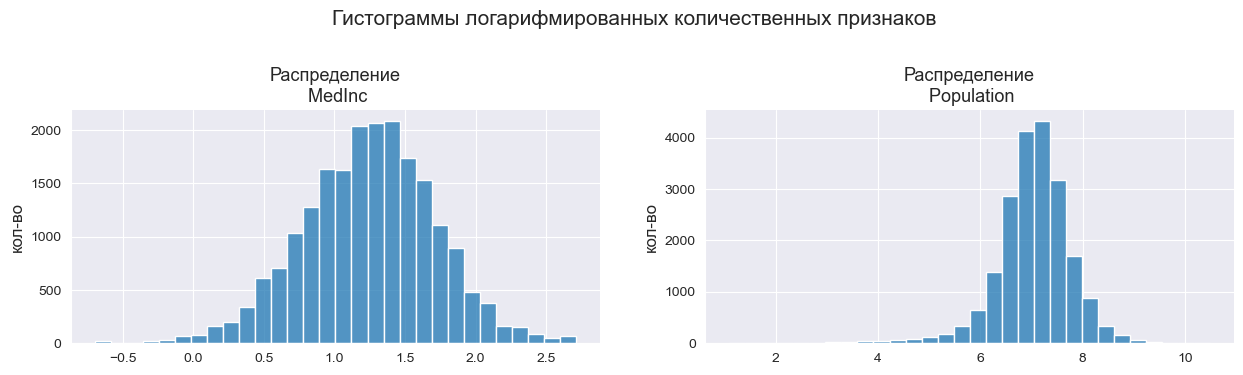

In [34]:
fig = plt.figure(figsize=(15,20))
cols = cols_for_math
for i,col in enumerate(cols):
    fig.add_subplot(5, 2, i+1)
    sns.histplot(data=df_4, x=col, kde=False, bins=30)
    plt.title(f'Распределение\n {col}', size=13)
    plt.xlabel('', size=12)
    sns.despine()
    plt.ylabel('кол-во', size=12)
plt.suptitle('Гистограммы логарифмированных количественных признаков', size=15, y=0.93)
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

In [35]:
res_4 = get_score(df_4, 'MedHouseVal', title='Math')

In [36]:
res = pd.concat([res, res_4], axis=1)
res

,Baseline,Drop_target_outlers,Drop_corr,Drop_all_outlers,Math
r2_train,0.613,0.541,0.518,0.564,0.469
r2_test,0.576,0.521,0.500,0.546,0.456
rmse_train,0.720,0.628,0.802,0.645,0.842
rmse_test,0.746,0.659,0.810,0.651,0.844


Очень странно, но после приведения признаков к более нормальному виду метрики заметно ухудшились.

#### 8\* Геолокация

Определение районов на 20000 точках координат займет много времени чтобы сократить его сделаем следующее:
1. Для каждого дома округлим координаты до 1 знака после запятой
2. Создадим словарь, где ключами будут кортежи пар округленных координат, а значениями количество домов районе (таким образом сократим поиск в раза)
3. Пройдемся по ключам и перезапишем значения словаря на название района.
4. Сохраним словарь, закомментируем цикл.
5. При перезапуске ноутбука просто вызовем ранее сохраненный словарь.
6. Заменим координаты в исходном датасете на районы

In [37]:
df['Latitude_'] = df['Latitude'].apply(lambda x: round(x, 1))
df['Longitude_'] = df['Longitude'].apply(lambda x: round(x, 1))

In [38]:
# location = dict(pd.Series(zip(df['Latitude_'],df['Longitude_'])).value_counts())
# for k,v in tqdm(location.items()):
#     location[k] = revgc.search(k)[0]['name']

In [39]:
# with open('Downloads/location.pkl', 'wb') as f:
#     pickle.dump(location, f)

In [40]:
with open('Downloads/location.pkl', 'rb') as f:
    location = pickle.load(f)

In [41]:
n = 0
for k,v in location.items():
    n += 1
    print(f'округленные координаты: {k} район: {v}')
    if n > 10:
        break

округленные координаты: (34.0, -118.3) район: View Park-Windsor Hills
округленные координаты: (34.0, -118.2) район: Maywood
округленные координаты: (34.1, -118.3) район: Hollywood
округленные координаты: (33.9, -118.2) район: East Rancho Dominguez
округленные координаты: (37.8, -122.2) район: Piedmont
округленные координаты: (34.0, -118.4) район: Culver City
округленные координаты: (34.1, -118.2) район: South Pasadena
округленные координаты: (33.9, -118.3) район: Gardena
округленные координаты: (37.8, -122.4) район: San Francisco
округленные координаты: (33.8, -118.0) район: Stanton
округленные координаты: (34.2, -118.4) район: North Hollywood


In [42]:
df['Location'] = pd.Series(zip(df['Latitude_'], df['Longitude_'])).map(location)

Преобразуем значение района на количество упоминаний.

In [43]:
df_5 = get_count(df, ['Location'])

In [44]:
df_5.drop(columns=['Latitude', 'Longitude', 'Latitude_', 'Longitude_', 'AveBedrms'], inplace=True)

In [45]:
res_5 = get_score(df_5, 'MedHouseVal', title='Location')

In [46]:
res = pd.concat([res, res_5], axis=1)
res

,Baseline,Drop_target_outlers,Drop_corr,Drop_all_outlers,Math,Location
r2_train,0.613,0.541,0.518,0.564,0.469,0.527
r2_test,0.576,0.521,0.500,0.546,0.456,0.506
rmse_train,0.720,0.628,0.802,0.645,0.842,0.795
rmse_test,0.746,0.659,0.810,0.651,0.844,0.805


Преобразование геолокаций не произвело улучшений

#### В итоге:  
1. Метрики улучшились только при удалении выбросов в целевой переменной и в остальных признаках. Мне кажется удаляя выбросы мы сокращаем вариативность и размер датасета. Когда в модель поступит строка с выбросными признаками, не известно что она спрогнозирует целевую переменную.
2. Сокращение мультиколлинеарности, логарифмирование признаков и кодирование геолокаций привели к обратному результату
____
В целом в ходе работы полученные обратные от ожидаемых результаты